In [1]:
import numpy as np
import torch
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from evaluation import *    

/home/fe/hufe/miniconda3/envs/remote-sensing/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to /home/fe/hufe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/fe/hufe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
%cd ..

/home/fe/hufe/Documents/semester11/activelearning_ic


In [3]:
ids = np.load('evaluation/sorted_train_ids.npy')

In [4]:
train_classes = pd.DataFrame({'classses': open('evaluation/train_classes.txt').read().splitlines()})
val_classes = pd.DataFrame({'classses': open('evaluation/val_classes.txt').read().splitlines()})

In [5]:
def load_selected_ids(path):
    unlabeled = torch.load(path).numpy()
    selected_classes = ~np.isin(ids, unlabeled)
    data = pd.get_dummies(train_classes['classses'][selected_classes]).sum()
    return data

## Load the selected sample per cycle

In [6]:
# load all ids that were selected by the strategy (accumulated over all iterations)
dataframes = [load_selected_ids(f'results/cluster_image_0/08-02-2023-12-41/unlabeled/{i}/img_ids_rank_0') for i in range(8)]

# put them into a dataframe
cluster_selected_samples = pd.concat(dataframes, axis=1)

# remove the accummulation
for i in range(7,0,-1):
    cluster_selected_samples[i] = cluster_selected_samples[i] - cluster_selected_samples[i-1]

In [ ]:
dataframes = [load_selected_ids(f'results/cluster+confidence_0/02-03-2023-18-15/unlabeled/{i}/img_ids_rank_0') for i in range(8)]

# put them into a dataframe
cluster_conf_selected_samples = pd.concat(dataframes, axis=1)

# remove the accummulation
for i in range(7,0,-1):
    cluster_conf_selected_samples[i] = cluster_conf_selected_samples[i] - cluster_conf_selected_samples[i-1]

## Load the validation scores per cycle

In [10]:
val_folders_cluster = [f'validation/cluster_image_0/08-02-2023-12-41/val/{i}' for i in range(8)]
val_folders_conf_cluster = [f'validation/cluster+confidence_0/28-02-2023-14-01/val/{i}' for i in range(8)]

In [11]:
def get_val_metrics_per_sample(path, idx):
    bleus = []
    meteors = []
    rouges = []
    percentage = []

    references = load_references([f"val_references_{i}.txt" for i in range(5)])
    hypothesis = load_hypothesis(path)

    save_hypothesis(path, hypothesis)

    meteor_results = []
    bleu_results = []
    rouge_results = []

    for hypo, reference in zip(hypothesis, references):    
        hypo = hypo.replace('.', ' .') 
        reference =  [ref.replace('.', '') for ref in reference] 
        bl = bleu(reference, hypo)
        me = meteor(reference, hypo)
        ro = rouge(reference, hypo)

        bleu_results.append(bl)
        meteor_results.append(me)
        rouge_results.append(ro)
    
    return pd.DataFrame({'bleu': bleu_results, 'meteor': meteor_results, 'rouge': rouge_results, 'class': val_classes['classses'], 'idx': [idx]*len(bleu_results)})

In [ ]:
# THIS MAY TAKE A WHILE
metrics_cluster = [get_val_metrics_per_sample(val_folders_cluster[i], i) for i in range(8)]
metrics_cluster_conf = [get_val_metrics_per_sample(val_folders_conf_cluster[i], i) for i in range(8)]

## Correlation for Fusion: Positive

In [13]:
corrs = []
for i in range(8):
    corr = pd.DataFrame({'samples': cluster_conf_selected_samples[i], 'performance': metrics_cluster_conf[i].groupby('class').meteor.mean()}).corr()['samples']['performance']
    corrs.append(corr)
np.array(corrs).mean()

0.28082016894738093

## Correlation for diversity: negative

In [14]:
corrs = []
for i in range(8):
    corr = pd.DataFrame({'samples': cluster_selected_samples[i], 'performance': metrics_cluster[i].groupby('class').meteor.mean()}).corr()['samples']['performance']
    corrs.append(corr)
np.array(corrs).mean()

-0.015152264923900373

## Normalize the metrics 

In [15]:
# Subtract the mean of the meteor scores, so that a below average performace is negative. 
# Divide by standard deviation to ensure meaningful plot. 
for i in range(8):
    metrics_cluster[i].meteor -= metrics_cluster[i].meteor.mean()
    metrics_cluster[i].meteor /= metrics_cluster[i].meteor.std()

    metrics_cluster_conf[i].meteor -= metrics_cluster_conf[i].meteor.mean()
    metrics_cluster_conf[i].meteor /= metrics_cluster_conf[i].meteor.std()
    


In [50]:
for i in range(8):
    cluster_selected_samples[i] -= cluster_selected_samples[i].mean()
    cluster_selected_samples[i] /= cluster_selected_samples[i].std()

    cluster_conf_selected_samples[i] -= cluster_conf_selected_samples[i].mean()
    cluster_conf_selected_samples[i] /= cluster_conf_selected_samples[i].std()


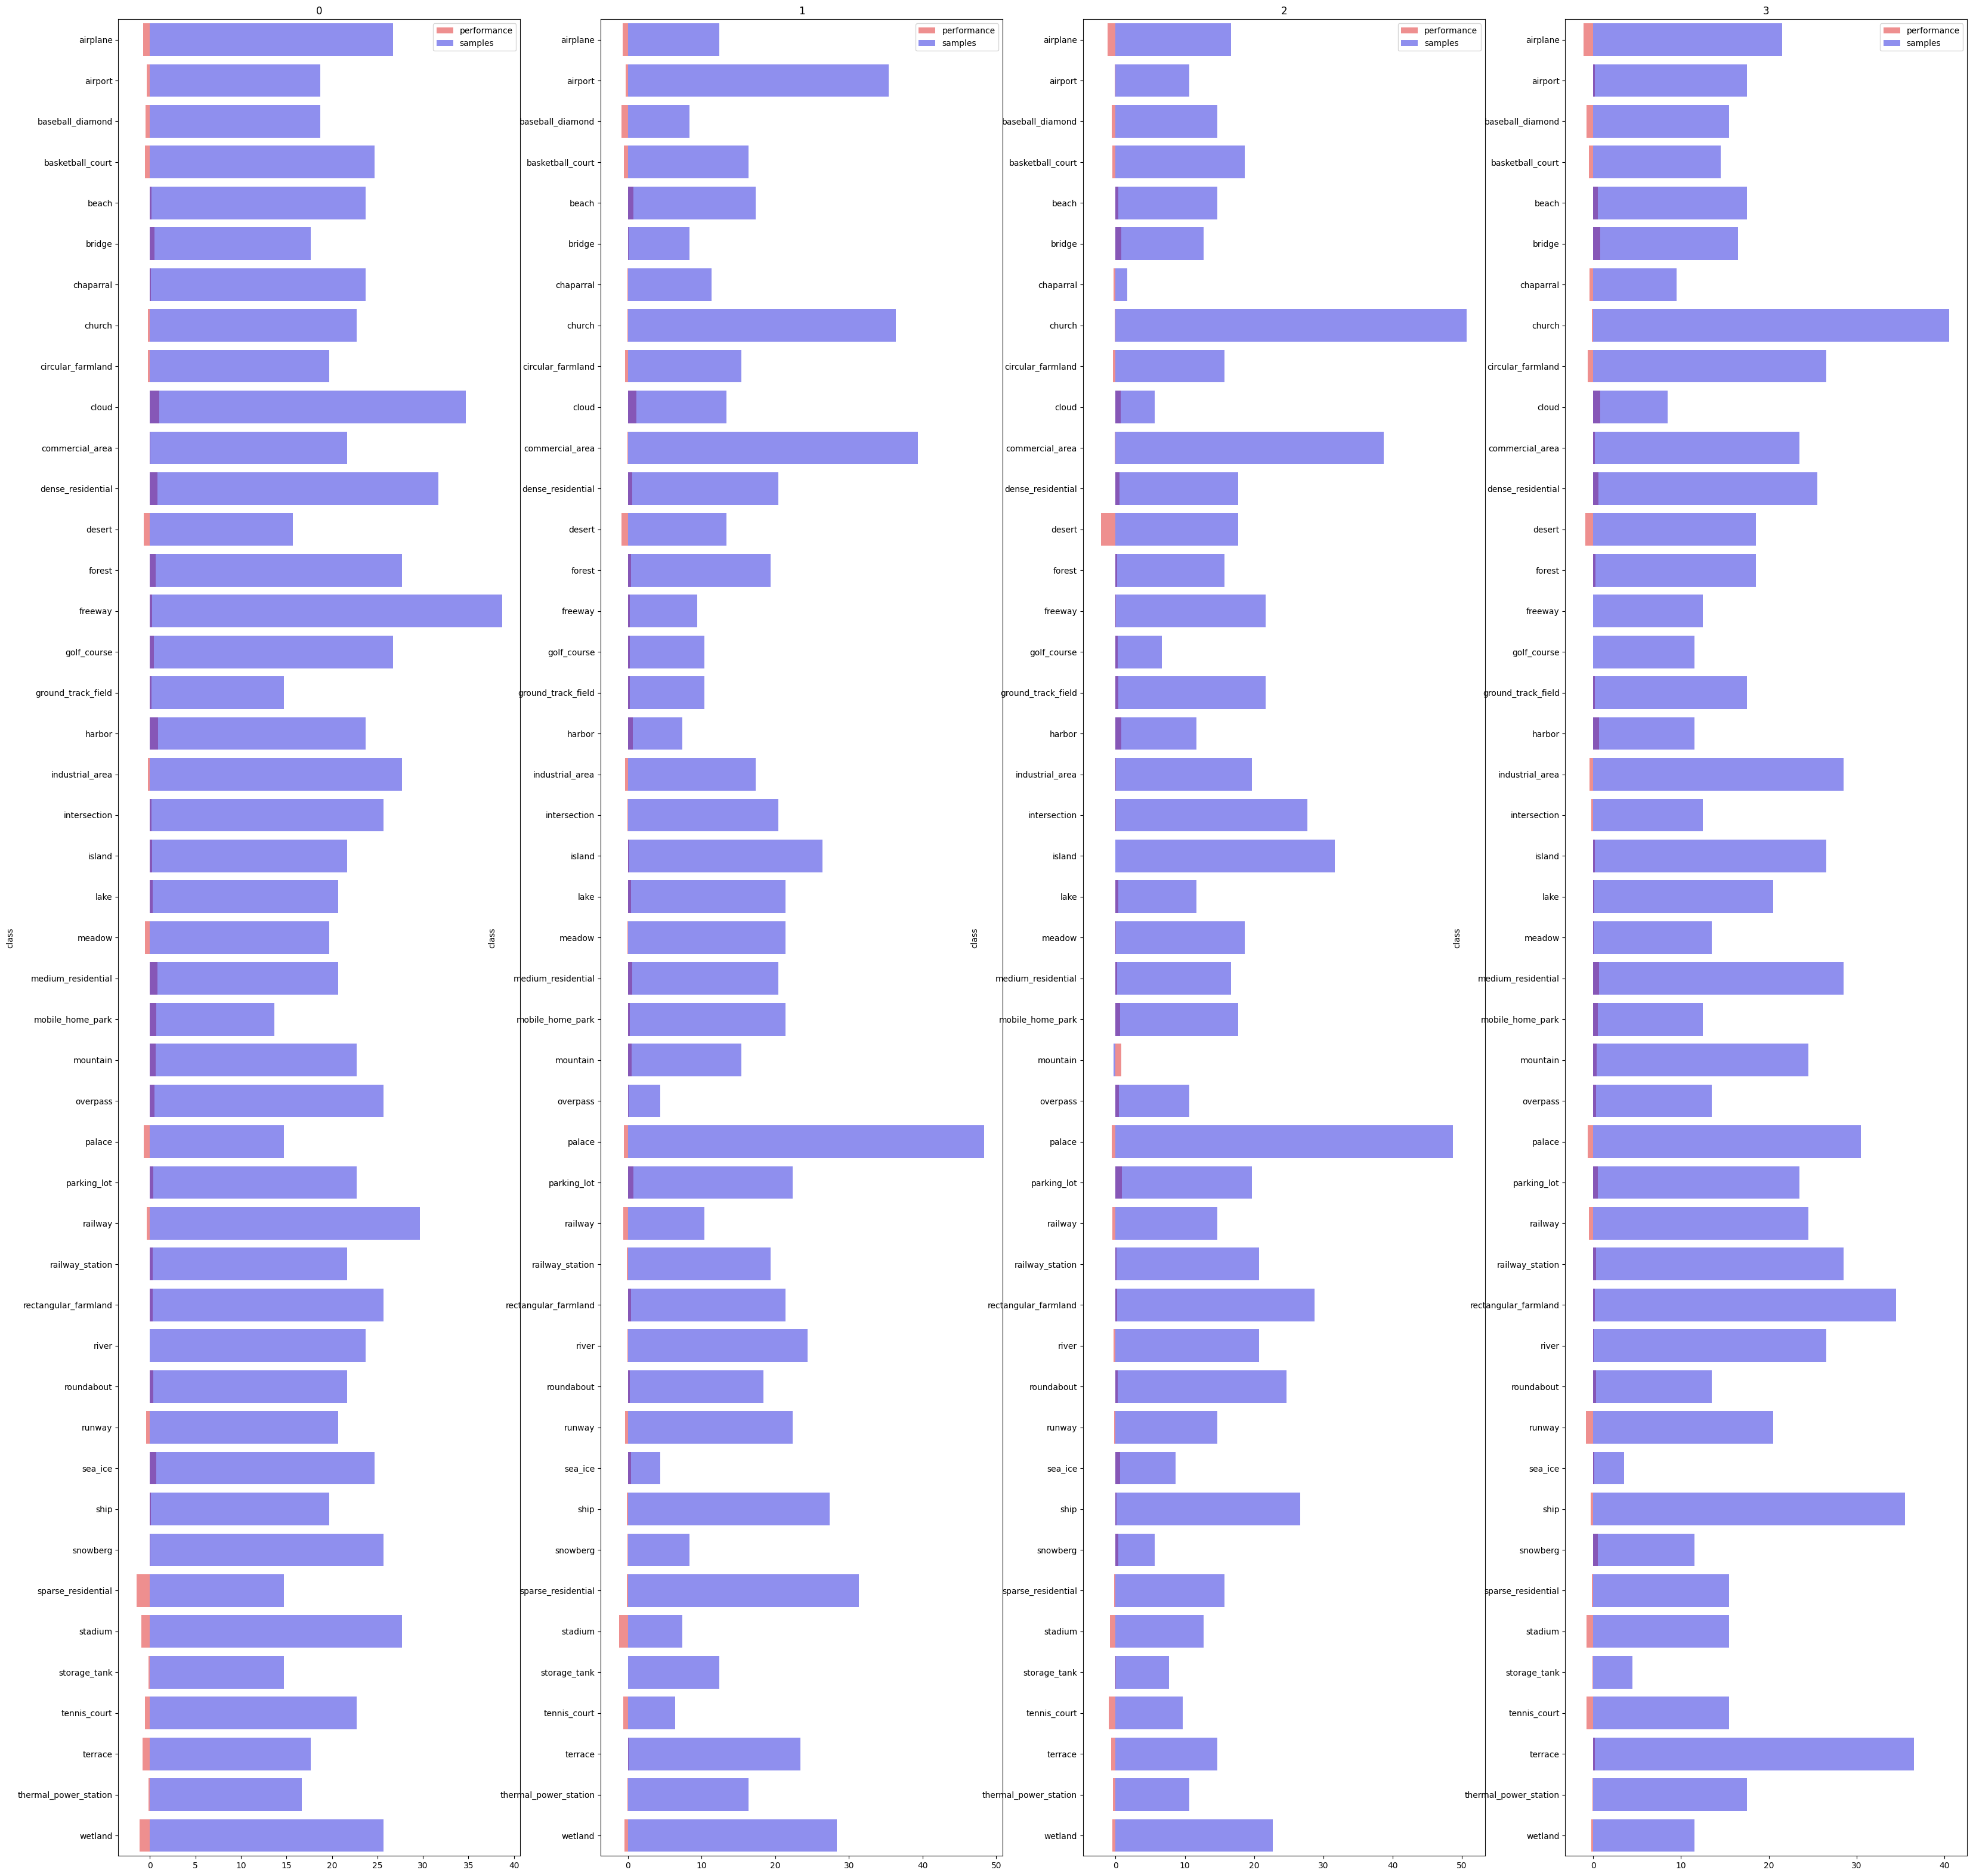

In [41]:

plt.figure(figsize=(40,40))
for i in range(4):
    plt.subplot(1,4,1+i, title=str(i))
    
    meteor_df = metrics_cluster[i].groupby('class').meteor.mean()
    
    sns.barplot(y=meteor_df.index, x=meteor_df.values, color='red', alpha=0.5, label='performance')
    sns.barplot(y=cluster_selected_samples[i].index, x=cluster_selected_samples[i].values, color='blue', alpha=0.5, label='samples')
    plt.legend()

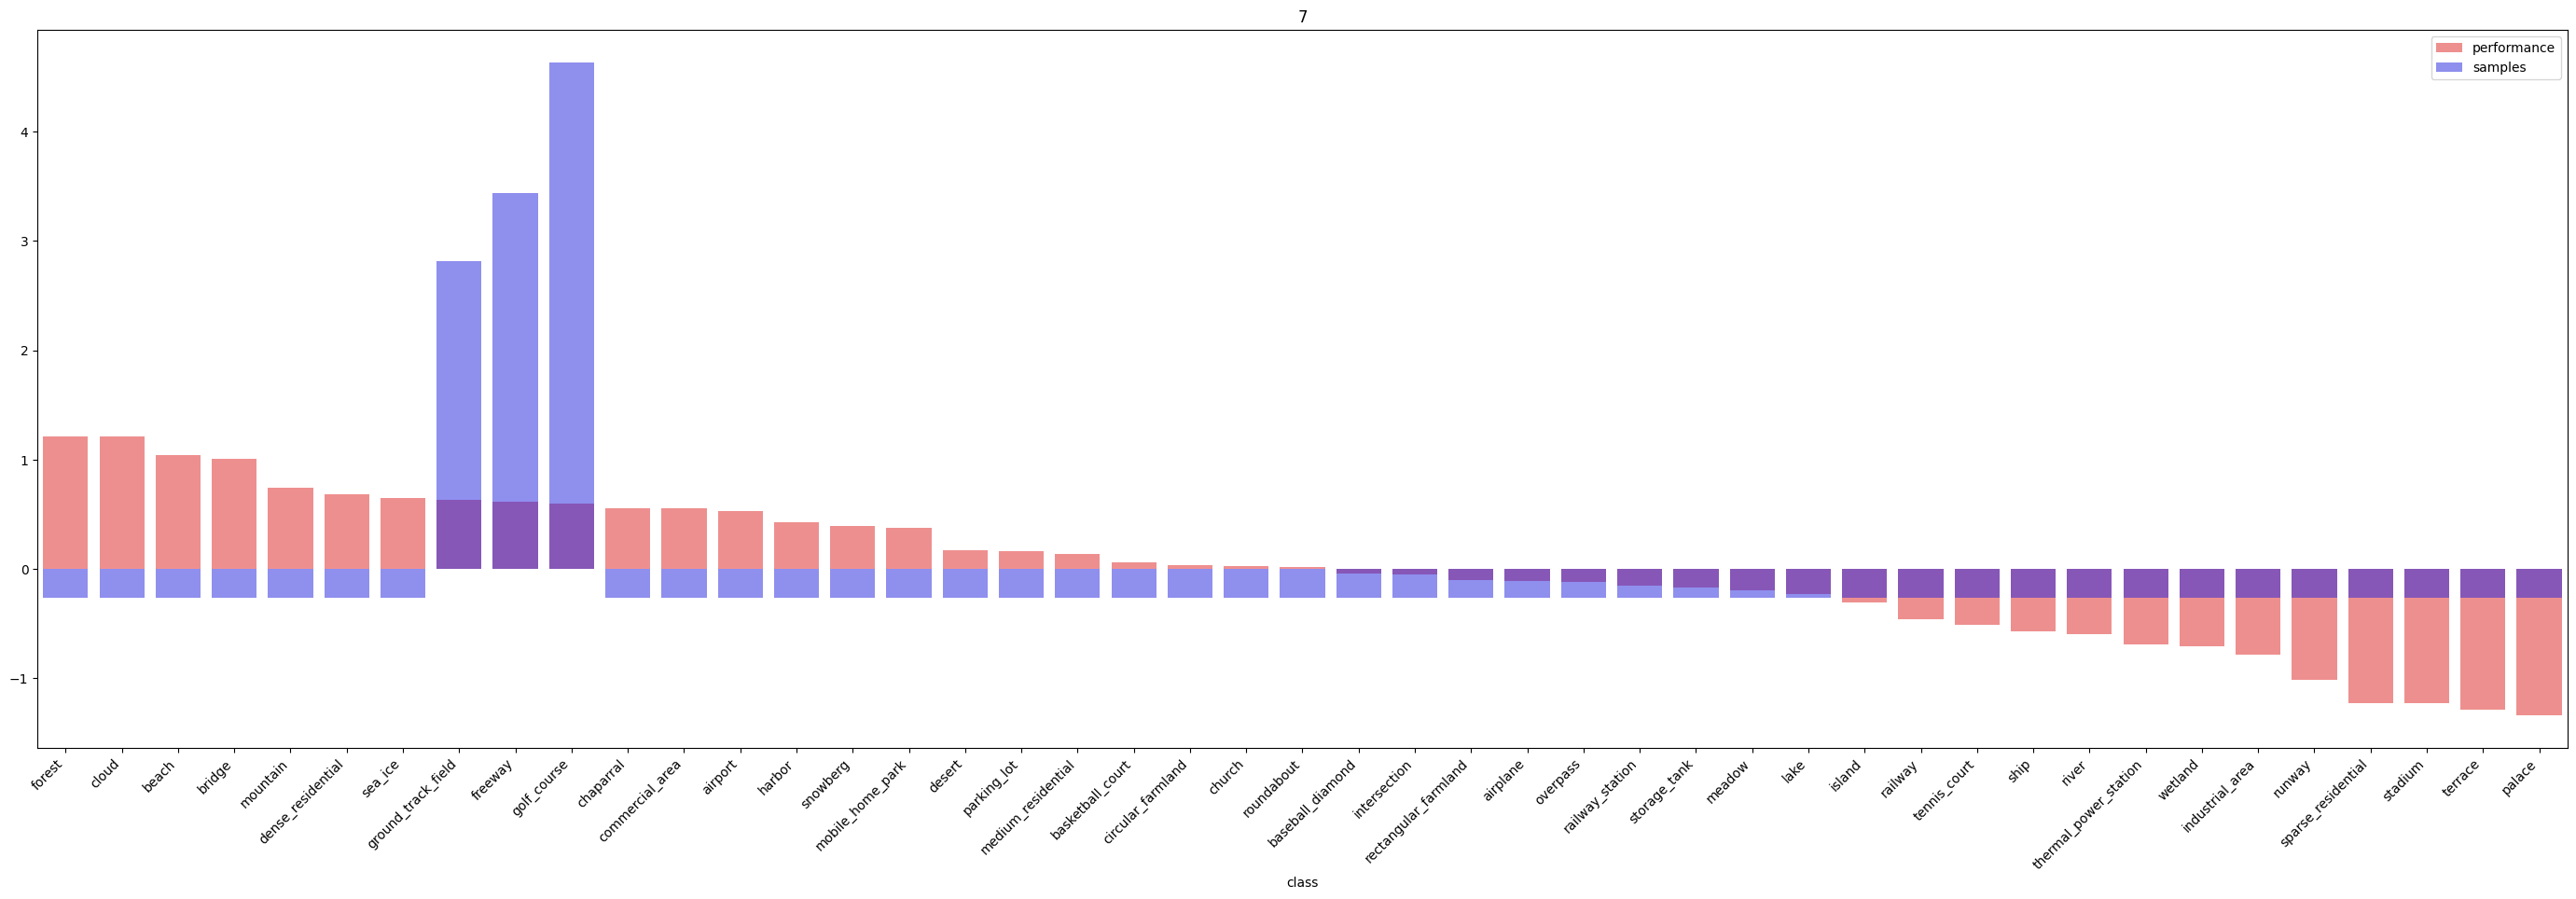

In [51]:
i=4

plt.figure(figsize=(35,10))
plt.subplot(1,1,1, title=str(i))


meteor_df = metrics_cluster_conf[i].groupby('class').meteor.mean()

order = meteor_df.sort_values(ascending=False).index

plt.xticks(rotation=45, ha='right')

sns.barplot(x=meteor_df.index, y=meteor_df.values, color='red', alpha=0.5, label='performance', order=order)
sns.barplot(x=cluster_conf_selected_samples[i].index, y=cluster_conf_selected_samples[i].values, color='blue', alpha=0.5, label='samples', order=order)
plt.legend()

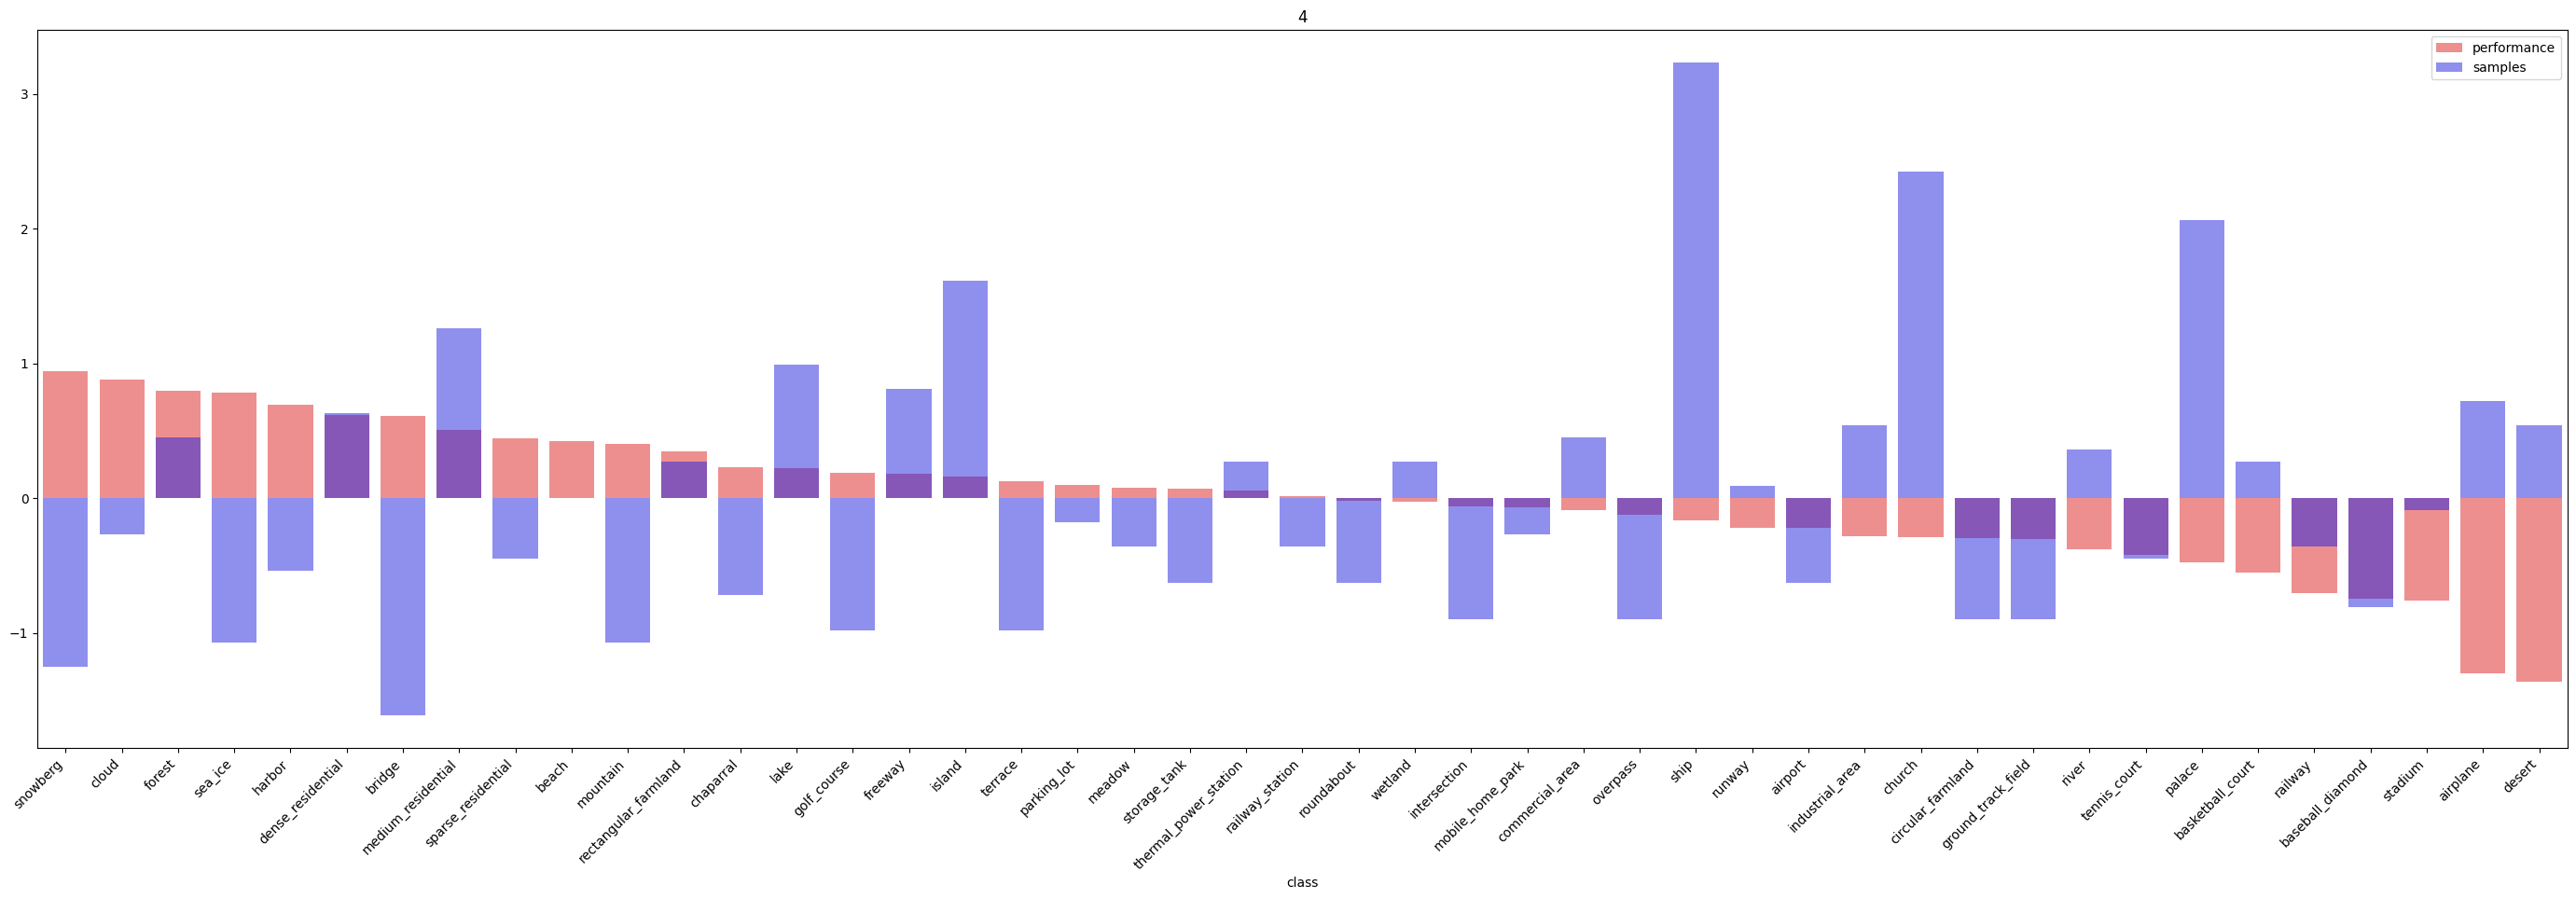

In [55]:

plt.figure(figsize=(35,10))
# for i in range(4):
i=4
plt.subplot(1,1,1, title=str(i))

meteor_df = metrics_cluster[i].groupby('class').meteor.mean()

order = meteor_df.sort_values(ascending=False).index

plt.xticks(rotation=45, ha='right')

sns.barplot(x=meteor_df.index, y=meteor_df.values, color='red', alpha=0.5, label='performance', order=order)
sns.barplot(x=cluster_selected_samples[i].index, y=cluster_selected_samples[i].values, color='blue', alpha=0.5, label='samples', order=order)
plt.legend()